The purpose of this notebook is to do some initial proof-of-concept work investigating various burn severity metrics within Joshua Tree National Park and Mojave Valley National Preserve.

Importing required packages:

In [152]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import requests
import matplotlib
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
import rioxarray
import stackstac
import contextily as ctx
from src.burn_severity import (
    read_band_image_from_stac_item_collection,
    calc_nbr,
    calc_dnbr,
    calc_rdnbr,
    calc_rbr,
    reclassify,
    reproject_shp_gdal,
    array2raster,
    clip_raster,
    reclassify,
)
from src.query_sentinel import Sentinel2Client
from src.ingest_BARC import ingest_BARC_zip_file

In [154]:
SENTINEL2_PATH = "https://earth-search.aws.element84.com/v1"
response = requests.get(SENTINEL2_PATH)
print(response.json())

{'stac_version': '1.0.0', 'type': 'Catalog', 'id': 'earth-search-aws', 'title': 'Earth Search by Element 84', 'description': 'A STAC API of public datasets on AWS', 'links': [{'rel': 'self', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1'}, {'rel': 'root', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1'}, {'rel': 'conformance', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/conformance'}, {'rel': 'data', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/collections'}, {'rel': 'search', 'type': 'application/geo+json', 'href': 'https://earth-search.aws.element84.com/v1/search', 'method': 'GET'}, {'rel': 'search', 'type': 'application/geo+json', 'href': 'https://earth-search.aws.element84.com/v1/search', 'method': 'POST'}, {'rel': 'aggregate', 'type': 'application/json', 'href': 'https://earth-search.aws.element84.com/v1/aggregate', 'method': 'GET'}, {'rel': 'aggreg

The following is an excerpt from the [proposed scope of work](https://docs.google.com/document/d/1Mwad8O_T7LjNUSiKOD9egrlos9rd9EsNK09ABFrGQdA) between the NPS and DSE. Essentially, this notebook aims to validate the assumption baked into this proposal - that BAER / BARC maps (and the dNBR approach they employ) are insufficient estimates of burn severity in JOTR and MVNP. 

We will first investigate this by getting the BARC maps via the online portal, using the extent of those maps to query SentinelHub for sentinel2 data, and making some comparisons between the various classifications derived from each metric.

### Step 1 - Develop Data / Modelling Infrastructure

Inputs:
- High frequency, low spatial resolution, highest spectral resolution remote sensing data
	- `Sentinel-2`, ~~`LANDSAT`, `MODIS`~~
- ~~Low frequency, higher spatial resolution, low spectral resolution~~
	- ~~National Agricultural Imagery Program (`NAIP`)~~
- ~~One-off frequency, extremely high spatial resolution, variable spectral resolution~~
	- ~~LIDAR imagery from previous survey work~~

In the context of fire severity modelling, absolute metrics, such as the *Normalized Burn Ratio* ($NBR$), tend to be more effective for comparison across high and low biomass areas, but tend to be biased low in low biomass areas since the absolute changes ($dNBR$) are small in magnitude according to lack of adjustment. 

$$ NBR = \frac{NIR - SWIR}{NIR + SWIR} $$
$$ dNBR = NBR_{prefire} - NBR_{postfire}$$

To address these issues, some commonly accepted adjustments include the *Relative Difference in Normalized Burn Ratio* ($RdNBR$), as well as the *Relativized Burn Ratio* ($RBR$),  both of which attempt to adjust the relative change by the reflectance of the area pre-fire, such that fire severity is scaled to local reflectance in each given pixel.

$$RdNBR = \frac{dNBR}{|(NBR_{prefire})^{0.5}|}$$

$$ RBR = \frac{dNBR}{NBR_{prefire} +1.001}$$
Each of these metrics can be derived from satellite imagery, at various degrees of temporal and spatial resolution. The simplest approach would be to settle on one source (likely `Sentinel-2`, as it has the higher temporal resolution than `MODIS` and `LANDSAT`), and interpolate values between collection. However, a particular challenge identified in the case of immediate post-fire analysis is the potential occlusion of smoke - most approaches employ some manual approaches to find the best available pre-fire and post-fire images, which could lead to (1) some vegetative cover/biomass bias due phenology between image dates or (2) lag in analysis time in waiting for smoke-free imagery to be collected, since satellites return at best every 5 days. 

If we discover that relying on a imaging source is insufficient, either due to a lack of timeliness in imaging after fire (due to smoke or cloud occlusion) or simply due to issues with ground-truth accuracy (described in step 2), we may investigate a method which incorporates multiple imagery sources, as illustrated with `ESTARFM` fusion model employed in *Liu et. al. 2022*. 

First, we can grab the relevant data from the USGS' online portal (https://burnseverity.cr.usgs.gov/viewer/?product=BAER):

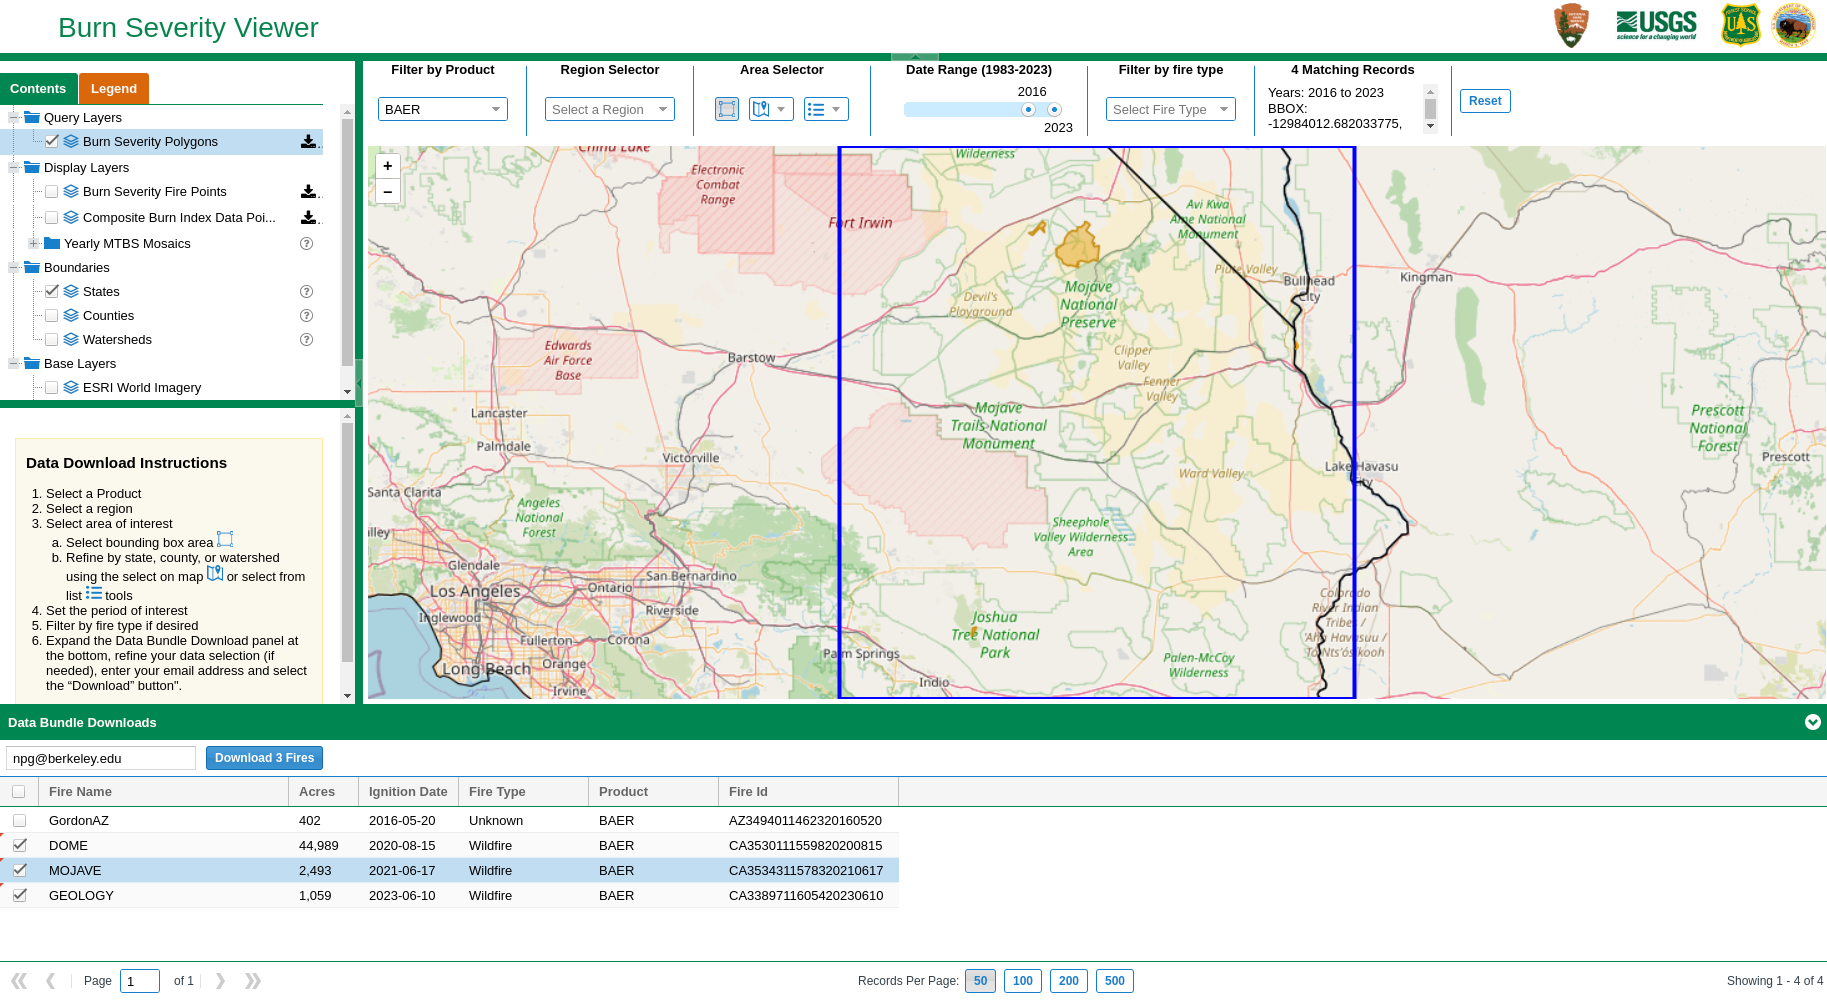

In [155]:
BARC_shps = ingest_BARC_zip_file("data/baer/2020/ca3530111559820200815.zip")

Found shapefile: ca3530111559820200815_20200808_20200902_burn_bndy.shp
Found shapefile: ca3530111559820200815_20200808_20200902_mask.shp


In [156]:
dome_boundary = BARC_shps[0]
dome_boundary

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,CA3530111559820200815,60146AC0-3AC8-462B-AC80-60D31F1B4D96,DOME,Wildfire,10015640,BAER,Emergency,44989,35.304,-115.589,...,None,-12,11,0,0,0,0,0,NIFS from 8/25 with minor edits,"POLYGON ((-1748536.243 1535050.001, -1748538.2..."


In [157]:
dome_boundary

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,CA3530111559820200815,60146AC0-3AC8-462B-AC80-60D31F1B4D96,DOME,Wildfire,10015640,BAER,Emergency,44989,35.304,-115.589,...,None,-12,11,0,0,0,0,0,NIFS from 8/25 with minor edits,"POLYGON ((-1748536.243 1535050.001, -1748538.2..."


<Axes: >

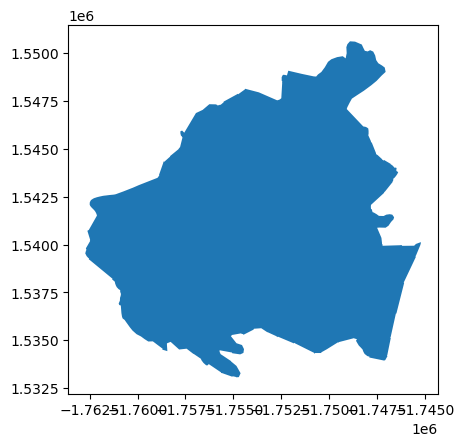

In [158]:
dome_boundary.plot()

In [159]:
dome_boundary.crs

<Projected CRS: ESRI:102039>
Name: USA_Contiguous_Albers_Equal_Area_Conic_USGS_version
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [160]:
dome_boundary = dome_boundary.to_crs("EPSG:4326")
dome_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [161]:
s2_client_dome = Sentinel2Client(
    geojson_bounds=dome_boundary.geometry,
    buffer=0
)

In [162]:
s2_client_dome.bbox

[-115.69, 35.22, -115.49, 35.39]

In [163]:
dome_items = s2_client_dome.query(
    date_range=("2020-08-01","2021-08-14"),
    from_bbox=True
)


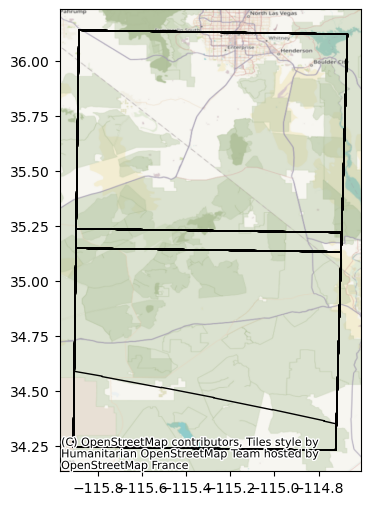

In [164]:
df = gpd.GeoDataFrame.from_features(dome_items.to_dict(), crs="epsg:4326")

ax = df[["geometry", "datetime", "s2:mgrs_tile", "eo:cloud_cover"]].plot(
    facecolor="none", figsize=(12, 6)
)
ctx.add_basemap(ax, crs=df.crs.to_string());

In [183]:

stac_endpoint_crs = dome_items[0].properties["proj:epsg"]
stac_endpoint_crs


32611

In [165]:
tst_item = dome_items[0]
tst_item

<Item id=S2B_MSIL2A_20210813T181919_R127_T11SPU_20210814T074156>

In [166]:
dome_stack = stackstac.stack(
    dome_items,
    epsg=32611,
    resolution=20,
    assets=["B8A", "B12"]
)
dome_stack.rio.write_crs("EPSG:32611", inplace=True)

/opt/conda/envs/burn-severity/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-b1209018827a6b14025fdd8aa0857a60' (time: 148,
                                                                band: 2,
                                                                y: 10491,
                                                                x: 5490)>
dask.array<fetch_raster_window, shape=(148, 2, 10491, 5490), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/45)
  * time                                     (time) datetime64[ns] 2020-08-03...
    id                                       (time) <U54 'S2A_MSIL2A_20200803...
  * band                                     (band) <U3 'B8A' 'B12'
  * x                                        (x) float64 6e+05 ... 7.098e+05
  * y                                        (y) float64 4e+06 ... 3.79e+06
    eo:cloud_cover                           (time) float64 0.2421 ... 24.13
    ...                                       ...
    title                                    (band) <U37 'Band 8A - Vegetatio...
    common_name                              (band) <U7 'rededge' 'swir22'
    center_wavelength                        (band) float64 0.865 2.19
    full_width_half_max                      (band) float64 0.033 0.242
    epsg                                     int64 32611
    spatial_ref                              int64 0
Attributes:
    spec:        RasterSpec(epsg=32611, bounds=(600000, 3790200, 709800, 4000...
    transform:   | 20.00, 0.00, 600000.00|\n| 0.00,-20.00, 4000020.00|\n| 0.0...
    resolution:  20

In [167]:
## Calculate median value for each band, across the entire time window
dome_stack_med = dome_stack.median(dim="time")

In [168]:
dome_stack_med

<xarray.DataArray 'stackstac-b1209018827a6b14025fdd8aa0857a60' (band: 2,
                                                                y: 10491,
                                                                x: 5490)>
dask.array<nanmedian, shape=(2, 10491, 5490), dtype=float64, chunksize=(1, 336, 336), chunktype=numpy.ndarray>
Coordinates: (12/20)
  * band                                     (band) <U3 'B8A' 'B12'
  * x                                        (x) float64 6e+05 ... 7.098e+05
  * y                                        (y) float64 4e+06 ... 3.79e+06
    s2:degraded_msi_data_percentage          float64 0.0
    s2:datatake_type                         <U8 'INS-NOBS'
    sat:orbit_state                          <U10 'descending'
    ...                                       ...
    title                                    (band) <U37 'Band 8A - Vegetatio...
    common_name                              (band) <U7 'rededge' 'swir22'
    center_wavelength                        (band) float64 0.865 2.19
    full_width_half_max                      (band) float64 0.033 0.242
    epsg                                     int64 32611
    spatial_ref                              int64 0

In [169]:
#set dome_boundary to have same CRS as our sentinel2 data
dome_boundary = dome_boundary.to_crs(dome_stack_med.rio.crs)
dome_buffered_boundary = dome_boundary.geometry.buffer(.25).values


In [170]:
dome_med_clipped = dome_stack_med.rio.clip(dome_buffered_boundary, dome_buffered_boundary.crs)

In [171]:
dome_med_clipped


<xarray.DataArray 'stackstac-b1209018827a6b14025fdd8aa0857a60' (band: 2,
                                                                y: 916, x: 875)>
dask.array<getitem, shape=(2, 916, 875), dtype=float64, chunksize=(1, 336, 336), chunktype=numpy.ndarray>
Coordinates: (12/20)
  * band                                     (band) <U3 'B8A' 'B12'
  * x                                        (x) float64 6.196e+05 ... 6.371e+05
  * y                                        (y) float64 3.917e+06 ... 3.899e+06
    s2:degraded_msi_data_percentage          float64 0.0
    s2:datatake_type                         <U8 'INS-NOBS'
    sat:orbit_state                          <U10 'descending'
    ...                                       ...
    title                                    (band) <U37 'Band 8A - Vegetatio...
    common_name                              (band) <U7 'rededge' 'swir22'
    center_wavelength                        (band) float64 0.865 2.19
    full_width_half_max                      (band) float64 0.033 0.242
    epsg                                     int64 32611
    spatial_ref                              int64 0

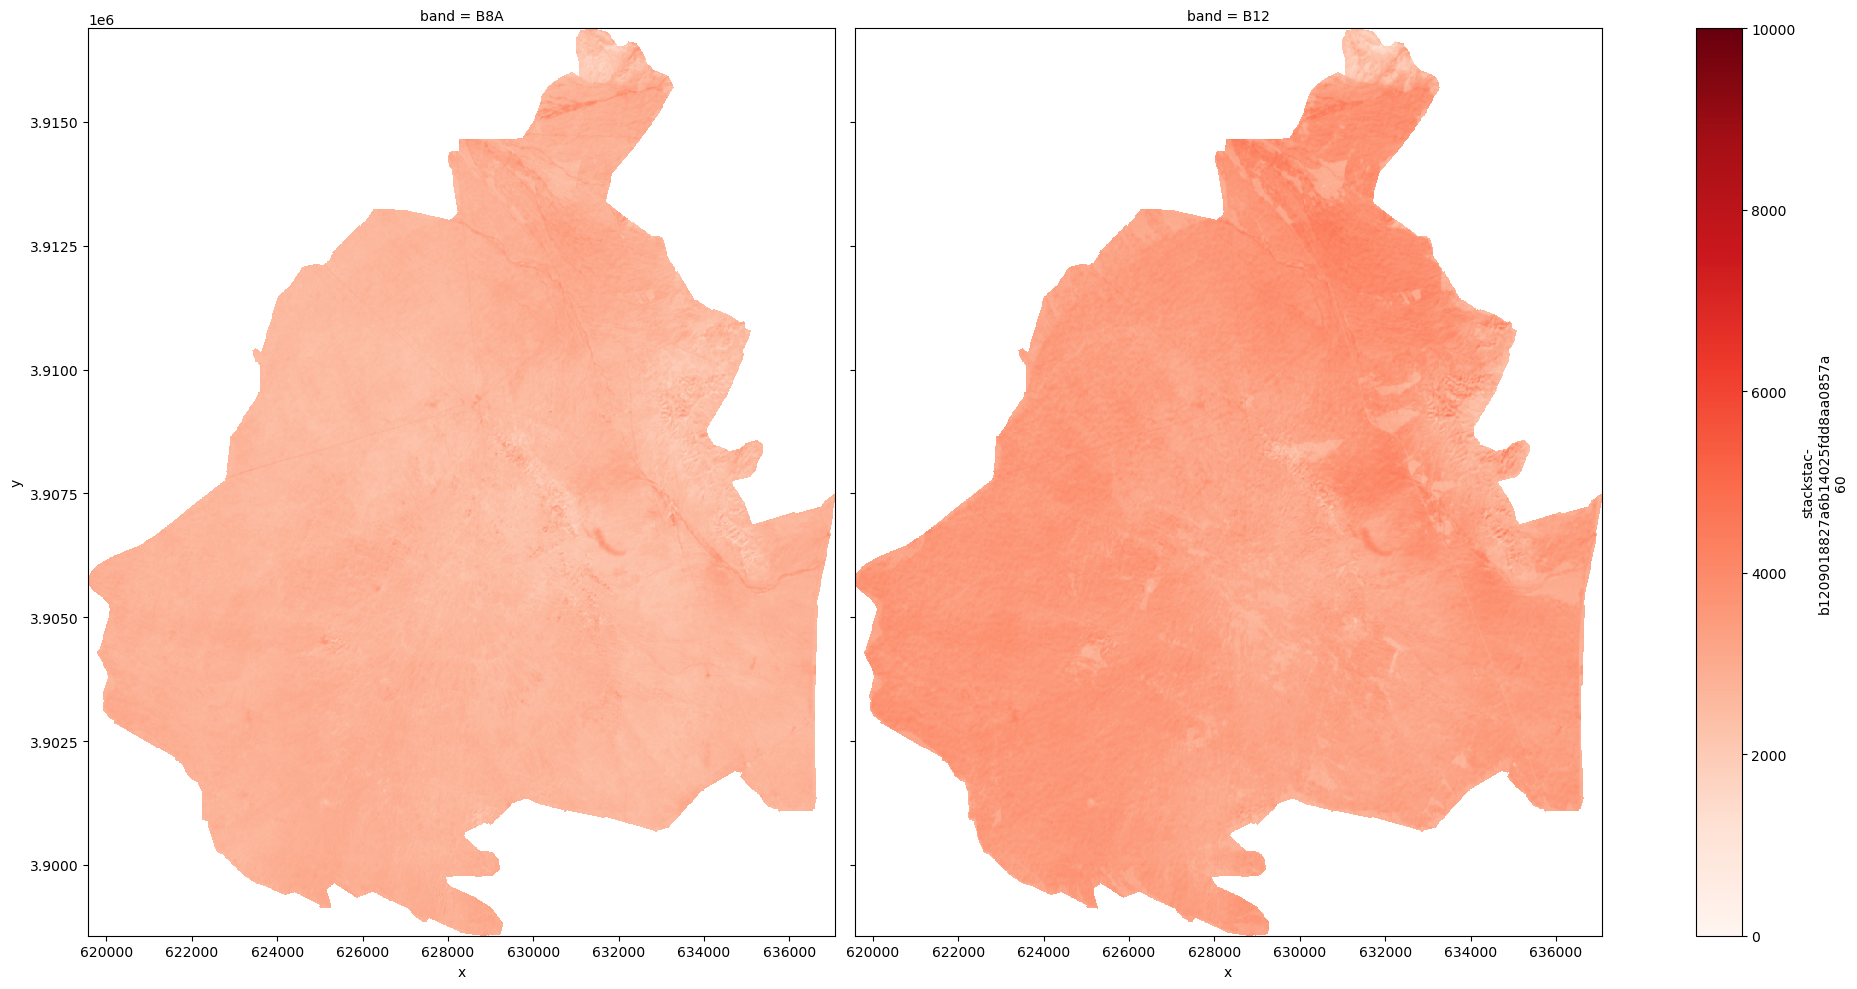

In [172]:
dome_med_clipped.plot(
    col="band",
    x="x",
    y="y",
    col_wrap=2,
    cmap="Reds",
    figsize=(20, 10),
    vmin=0,
    vmax=10000
);

plt.show()

### Calculating Burn Metrics

In [175]:
dome_NBR = (dome_med_clipped.sel(band="B8A") - dome_med_clipped.sel(band="B12"))  / (dome_med_clipped.sel(band="B8A") + dome_med_clipped.sel(band="B12"))

In [176]:
dome_NBR

<xarray.DataArray 'stackstac-b1209018827a6b14025fdd8aa0857a60' (y: 916, x: 875)>
dask.array<truediv, shape=(916, 875), dtype=float64, chunksize=(336, 336), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * x                                        (x) float64 6.196e+05 ... 6.371e+05
  * y                                        (y) float64 3.917e+06 ... 3.899e+06
    s2:degraded_msi_data_percentage          float64 0.0
    s2:datatake_type                         <U8 'INS-NOBS'
    sat:orbit_state                          <U10 'descending'
    s2:saturated_defective_pixel_percentage  float64 0.0
    ...                                       ...
    sat:relative_orbit                       int64 127
    s2:product_type                          <U7 'S2MSI2A'
    gsd                                      float64 20.0
    proj:shape                               object {5490}
    epsg                                     int64 32611
    spatial_ref                              int64 0

<Figure size 1000x1000 with 0 Axes>

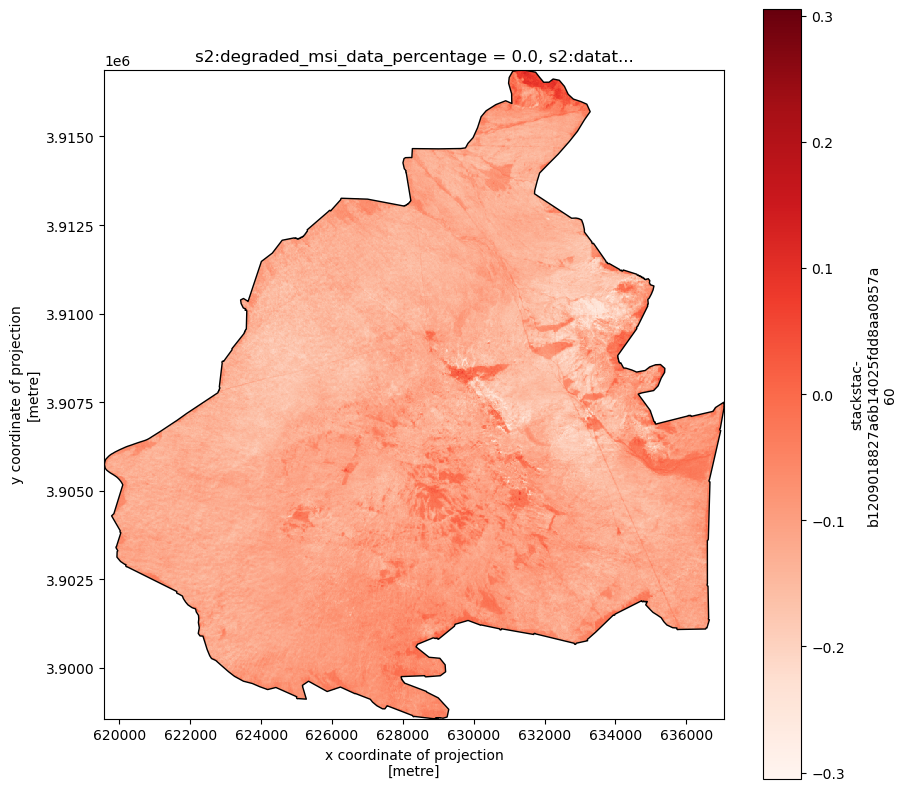

In [178]:
fig = plt.figure(figsize=(10, 10))
dome_NBR.plot(
    x="x",
    y="y",
    col_wrap=2,
    cmap="Reds",
    figsize=(10, 10),
);

# add the dome boundary to the plot
dome_boundary.plot(ax=plt.gca(), facecolor="none", edgecolor="black")

fig.suptitle("NBR")
fig.show()

------------

### HERE AND BELOW STALE FROM UN REPO


























-----------

In [9]:
# Paths
path_prefire = "F:/Burn_Severity/S2A_MSIL2A_20161220T143742_N0204_R096_T18HYF_20161220T145131.SAFE/GRANULE/L2A_T18HYF_A007815_20161220T145131/IMG_DATA/R20m/"
path_postfire = "F:/Burn_Severity/S2A_MSIL2A_20170218T143751_N0204_R096_T18HYF_20170218T145150.SAFE/GRANULE/L2A_T18HYF_A008673_20170218T145150/IMG_DATA/R20m/"
# Define shapefile
infile_shp = "F:/Burn_Severity/Empedrado_adm_boundary/Empedrado.shp"
# Define reprojected shapefile
outfile_shp = "F:/Burn_Severity/Empedrado_adm_boundary/projected.shp"
# name of the output dNBR raster file
filename = "F:/Burn_Severity/dNBR.tiff"
# name of clipped dNBR raster
filename2 = "F:/Burn_Severity/dNBR_clipped.tiff"
# path to save figure
fname = "F:/Burn_Severity/map.png"

# Sentinel-2 Bands used for NBR calculation 
band1 = '8A'
band2 = '12'
    
# Read the pre-fire band images 
(pre_fire_b8a, crs, geoTransform, targetprj) = read_band_image(band1, path_prefire)
(pre_fire_b12, crs, geoTransform, targetprj) = read_band_image(band2, path_prefire)
    
# Calculation of pre-fire NBR
pre_fire_nbr = nbr(pre_fire_b8a.astype(int),pre_fire_b12.astype(int))

# Read the post-fire band images
(post_fire_b8a, crs, geoTransform, targetprj) = read_band_image(band1, path_postfire)
(post_fire_b12, crs, geoTransform, targetprj) = read_band_image(band2, path_postfire)
    
# Calculation of post-fire NBR
post_fire_nbr = nbr(post_fire_b8a.astype(int),post_fire_b12.astype(int))
    
# Calculation of dNBR
DNBR = dnbr(pre_fire_nbr,post_fire_nbr)
    
# Reprojection of shapefile with gdal to match projection of Sentinel-2 images
reproject_shp_gdal(infile_shp, outfile_shp, targetprj)
    
# Read the reprojected shapefile
fire_boundary = gpd.read_file(outfile_shp)
    
# project dNBR to images projection
dnbr_tif, dnbr_tifBand = array2raster(DNBR, geoTransform, crs, filename)
    
# clip raster dNBR file to Empedrado shapefile
(clipped_dnbr, clipped_dnbr_meta, cr_extent, gt) = clip_raster(filename, fire_boundary)
clipped_ds , clipped_ds_rasterband = array2raster(clipped_dnbr[0], gt, crs, filename2)


Plot the results

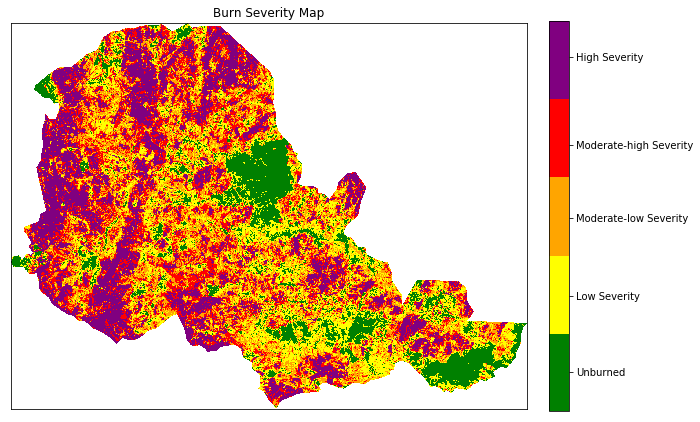

<Figure size 432x288 with 0 Axes>

In [10]:
# plot 

#set colors for plotting and classes
cmap = matplotlib.colors.ListedColormap(['green','yellow','orange','red','purple'])
cmap.set_over('purple')
cmap.set_under('white')
bounds = [-0.5, 0.1, 0.27, 0.440, 0.660, 1.3]        
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)  

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(clipped_ds_rasterband.ReadAsArray(), cmap=cmap, norm = norm)
plt.title('Burn Severity Map')
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04, ticks=[-0.2, 0.18, 0.35, 0.53, 1])
cbar.ax.set_yticklabels(['Unburned', 'Low Severity', 'Moderate-low Severity', 'Moderate-high Severity', 'High Severity'])
plt.show()
plt.savefig(fname, bbox_inches="tight") 
        

Calculate burnt area

In [11]:
# calculate burnt area (pixel size 20m*20m)
reclass = reclassify(clipped_ds_rasterband.ReadAsArray())
k = ['Unburned hectares', 'Low severity hectares', 'Moderate-low severity hectares', 'Moderate-high severity hectares', 'High severity']
for i in range(1,6):
    x = reclass[reclass == i]
    l= x.size*0.04
    print("%s: %.2f" % (k[i-1], l))

Unburned hectares: 7700.64
Low severity hectares: 11181.32
Moderate-low severity hectares: 12470.92
Moderate-high severity hectares: 11940.44
High severity: 13272.32
